In [ ]:
# Installing Cudnn
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66
!pip install tensorflow-io==0.25.0
!pip install tensorflow-addons

In [2]:
# import libraries

import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import cv2 as cv
import time
import itertools
import random


import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
import tensorflow_io as tfio
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
from tensorflow.keras import applications
from tensorflow.keras import metrics


from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
import warnings
import matplotlib.image as mpimg
from functools import reduce
warnings.filterwarnings('ignore')

In [3]:
!pip install gdown

In [4]:
!gdown --id 0B29vNACcjvzVc1RfVkg5dUh2b1E

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B29vNACcjvzVc1RfVkg5dUh2b1E
From (redirected): https://drive.google.com/uc?id=0B29vNACcjvzVc1RfVkg5dUh2b1E&confirm=t&uuid=31a34612-ed90-459a-a5c8-ba6c10b0059b
To: /content/BHSig260.zip
100% 48.5M/48.5M [00:01<00:00, 35.3MB/s]


## About the Dataset

- The dataset consists of 2 directories Hindi and Bengali Signatures.
- The Hindi directory consists of 160 sub-directories which are the signatures of 160 people
- The Bengali directory consists of 100 sub-directories which are the signatures of 100 people.
- Each person has 24 genuine Signatures followerd by  30 forged signatures.

In [5]:
!mkdir signatures

In [ ]:
! unzip BHSig260.zip -d signatures

In [7]:
path = "./signatures/BHSig260/Hindi/"

In [ ]:
dir_list = next(os.walk(path))[1]

In [ ]:
dir_list.sort()

In [ ]:
print(len(dir_list))
dir_list[:6]

160


['001', '002', '003', '004', '005', '006']

For each person segregate the genuine signatures from the forged signatures
Genuine signatures are stored in the list **orig_groups**
Forged signatures are stored in the list **forged_groups**

---
Here, First 30 signatures in each folder are **forged**
Next 24 signatures are **genuine**




In [ ]:
orig_groups, forged_groups = [], []
for directory in dir_list:
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forged_groups.append(images[:30])
  orig_groups.append(images[30:])

In [ ]:
len(forged_groups[0]), len(orig_groups[0])

(30, 24)

In [ ]:
# we had 160 individuals
len(forged_groups), len(orig_groups)

(160, 160)

To train a model for Signature verification, we need a **input image** and a **validation image** to check whether the validation image is a forgery or not.

In our Dataset, we have a file a **Hindi_pairs.txt**. It consists of image pairs and their respective label.

For example,

- **001/H-S-1-G-01.tif** is Genuine signature of a person
- **001/H-S-1-F-01.tif** is Forgery signature of the same person

So the label of this pair will be 0
- If both the images are Genuine signature of the person, then the label will be 1


Now let's use this dataset and visualize the pairs for better understanding

In [ ]:
pairs = pd.read_csv(path+"Hindi_pairs.txt",delimiter=" ",header=None)

In [ ]:
/content/signatures/BHSig260

In [ ]:
pairs.head()

,0,1,2
0,001/H-S-1-G-01.tif,001/H-S-1-F-01.tif,0
1,001/H-S-1-G-02.tif,001/H-S-1-F-01.tif,0
2,001/H-S-1-G-03.tif,001/H-S-1-F-01.tif,0
3,001/H-S-1-G-04.tif,001/H-S-1-F-01.tif,0
4,001/H-S-1-G-05.tif,001/H-S-1-F-01.tif,0


In [ ]:
pairs.shape

(8964, 3)

In [ ]:
inp_imgs = []
val_imgs = []
labels = []

In [ ]:
for idx, row in pairs.iterrows():
  inp = row[0]
  val = row[1]
  label = row[2]
  inp_imgs.append(path+inp)
  val_imgs.append(path+val)
  labels.append(label)

In [ ]:
len(inp_imgs), len(val_imgs), len(labels)

(8964, 8964, 8964)

In [ ]:
# all images will be converted to the same size before processing
img_h, img_w = 180, 180

In [ ]:
# Let's visualize original and forged signature of a person

def visualize_sample_signature():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
  k = np.random.randint(len(pairs))
  inp = inp_imgs[k]
  val = val_imgs[k]

  # reading the image
  inp_img = mpimg.imread(inp)
  val_img = mpimg.imread(val)

  # displaying the image
  ax1.imshow(inp_img, cmap='gray')
  ax2.imshow(val_img, cmap='gray')

  ax1.set_title('Input Image')
  ax2.set_title('Validation Image')
  print(f"Label : {labels[k]}")

Label : 0


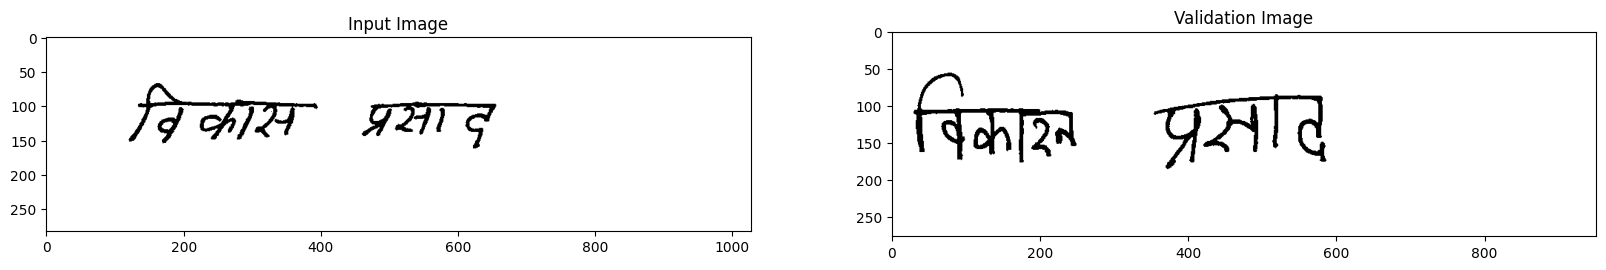

In [ ]:
visualize_sample_signature()

###Preparing data
Siamese Network has two identical sub-networks, one for the **input image** and other for the **validation image**.

For contrastive loss functions, the dataset should be in the form
- (anchor_image,positive_image,1)
- (anchor_image,negative_image,0)

> Since anchor image and positive image are same, it is similar. So the label is 1

> Anchor image and negative image are dis-similar. So the label is 0


In [ ]:
pairs_data = tf.data.Dataset.from_tensor_slices((inp_imgs, val_imgs))
pairs_label = tf.data.Dataset.from_tensor_slices(labels)
data = tf.data.Dataset.zip((pairs_data, pairs_label))

In [ ]:
data

<ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# pre-process the data required for contrastive loss

def preprocess_image(filename):

  image_string = tf.io.read_file(filename)
  # Decodes a .tiff encoded image tensor of RGBA format (Output shape-[height,width,4])
  image = tfio.experimental.image.decode_tiff(image_string)
  # Selecting only the 3 channels of the image - RGB
  r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
  # Combines multiple tensors
  image = tf.stack([r, g, b], axis = -1)
  image = tf.image.resize(image, (180, 180))
  return image

In [ ]:
preprocess_image('./signatures/BHSig260/Hindi/001/H-S-1-G-01.tif').shape

TensorShape([180, 180, 3])

**preprocess_image()**

- Reads Image
- Converts .tiff to tensor
- resizes the image to size (180,180)

**preprocess_twin**
- Returns **(input_image,validation_image,label)**



In [ ]:
# Function to preprocess image and return the tuple consisting of
# (input_image,validation_image,label)

def preprocess_twin(img_pair, label):
  input_img = img_pair[0]
  validation_img = img_pair[1]
  return {
      'input_img' : preprocess_image(input_img),
      'validation_img' : preprocess_image(validation_img)
  }, label

In [ ]:
example = data.as_numpy_iterator().next()

In [ ]:
len(example)

2

In [ ]:
example

((b'./signatures/BHSig260/Hindi/001/H-S-1-G-01.tif',
  b'./signatures/BHSig260/Hindi/001/H-S-1-F-01.tif'),
 0)

Installing tensorflow_io for decoding .tiff images using tensorflow

- **.shuffle()** - shuffles the samples in the dataset.

- **.map()** - transforms items in the dataset

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=len(data))

In [ ]:
# training partition
train_data = data.take(round(len(data)*0.8))
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

In [ ]:
val_data = data.skip(round(len(data)*0.8))
val_data = val_data.take(round(len(data)*0.15))
val_data = val_data.batch(4)
val_data = val_data.prefetch(2)

In [ ]:
# testing partition

test_data = data.skip(round(len(data)*0.95))
test_data = test_data.take(round(len(data)*0.5))
test_data = test_data.batch(4)
test_data = test_data.prefetch(2)

In [ ]:
len(train_data), len(val_data), len(test_data)

(1793, 337, 112)

In [ ]:
train_data

<PrefetchDataset element_spec=({'input_img': TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), 'validation_img': TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Siamese Network

###What should be the base CNN network?
- You can create Convolutions network from scratch extract features embeddings from the image.

- we can take the advantage of **pretrained models**

- Pretrained-models(Transfer learning) - You can also use pre-trained models like VGG16, Resnet50 to extract the feature embeddings.

- We will use the  pre-trained model **Resnet50** to train the embeddings to identify similar and dissimilar signatures
- ResNet-50 is a CNN that is 50 layers deep. It has been trained on millions of images from imagenet database and handles vanishing gradient problem in very deep CNNs.

In [ ]:
input_dim = (180, 180, 3)

In [ ]:
img1 = Input(180, 180, 3)
img2 = Input(180, 180, 3)
e1 = cnn()(img1)
e2 = cnn()(img2)

model= Model(inputs=[img1, img2], outputs=[e1, e2])

In [ ]:
base_cnn = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_dim)

base_cnn.trainable = False

glob_pool = layers.GlobalAveragePooling2D()(base_cnn.output)
dense1 = layers.Dense(128)(glob_pool)
output = layers.Dense(128)(dense1)

embedding = Model(base_cnn.input, output, name='Embedding')

# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable

94781440/94765736 [==============================] - 1s 0us/step


## How to compare the embeddings?:

- For that we will distance metric called 'Euclidean distance' to find how similar the two signatures are.

- But you can also use Cosine similarity

Function to Calculate Euclidean distance to calculate similariity between the input image and the validation image:



In [ ]:
def euclidean_distance(vects):
  # compute euclidean distance between two vectors
  x, y = vects
  return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

## Building the Siamese model

In [ ]:
# building model for feature extraction

# shape of the input
img_a = Input(shape=input_dim, name='input_img')
img_b = Input(shape=input_dim, name='validation_img')

# extracting embeddings of the image
feature_vecs_a = embedding(img_a)
feature_vecs_b = embedding(img_b)

# calculating euclidean distance between images
dist = Lambda(euclidean_distance)([feature_vecs_a, feature_vecs_b])
model = Model([img_a, img_b], dist)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 128)          23866496    ['input_img[0][0]',              
                                                                  'validation_img[0][0]']     

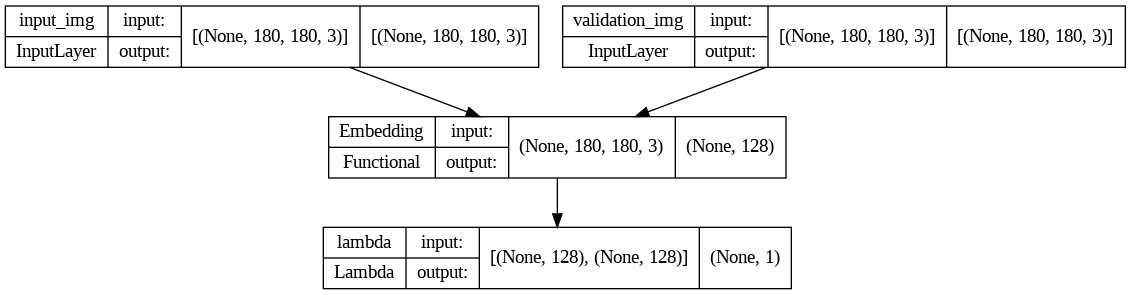

In [ ]:
# Plotting the architecture of siamese model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

### Contrastive Loss and Model performance

In [ ]:
def contrastive_loss(y, preds, margin=1):
  y = tf.cast(y, preds.dtype)
  squared_preds = K.square(preds)
  squared_margin = K.square(K.maximum(margin - preds, 0))
  loss = K.mean(y * squared_preds + (1 - y) * squared_margin)
  return loss

In [ ]:
# training the model with Adam optimizer and Contrastive loss

model.compile(loss=contrastive_loss, optimizer='adam')

In [ ]:
!mkdir Weights_binary

In [ ]:
callbacks = [
    ModelCheckpoint('./Weights_binary/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
history = model.fit(
    train_data,
    steps_per_epoch=50,
    epochs=20,
    validation_data=val_data,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 1.6472
Epoch 1: saving model to ./Weights_binary/signet-bhsig260-001.h5
50/50 [==============================] - 308s 2s/step - loss: 1.6472 - val_loss: 1.0055
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.5359
Epoch 2: saving model to ./Weights_binary/signet-bhsig260-002.h5
50/50 [==============================] - 103s 2s/step - loss: 1.5359 - val_loss: 1.2954
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.8826
Epoch 3: saving model to ./Weights_binary/signet-bhsig260-003.h5
50/50 [==============================] - 103s 2s/step - loss: 0.8826 - val_loss: 0.8667
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.9264
Epoch 4: saving model to ./Weights_binary/signet-bhsig260-004.h5
50/50 [==============================] - 104s 2s/step - loss: 0.9264 - val_loss: 0.6965
Epoch 5/20
50/50 [==============================] - ETA: 0s - loss: 0.6404
Epoch 5: savi

In [ ]:
# Downloading Best Model Weights
!gdown 1uuE37aN36fnp5s-7iSLShQSJw9sT_1Vs

Downloading...
From: https://drive.google.com/uc?id=1uuE37aN36fnp5s-7iSLShQSJw9sT_1Vs
To: /content/signet-bhsig260-020.h5
100% 95.7M/95.7M [00:00<00:00, 110MB/s]


In [ ]:
model.load_weights("/content/signet-bhsig260-020.h5")

Now, Let's compute the best threshold where the accuracy is maximum.

> **Accuracy = (tp + tn) / (tp + tn + fp + fn)**

- **TP** stands for True Positive, which is a case where the model correctly predicts a positive class when the true class is positive.

- **TN** stands for True Negative, which is a case where the model correctly predicts a negative class when the true class is negative.

- **FP** stands for False Positive, which is a case where the model incorrectly predicts a positive class when the true class is negative.

- **FN** stands for False Negative, which is a case where the model incorrectly predicts a negative class when the true class is positive.

> In other words, TP and TN represent correct predictions, while FP and FN represent incorrect predictions.

In [ ]:
# Finding out at which threshold, the accuracy is maximum

def compute_accuracy_threshold(predictions, labels):

  dmax = np.max(predictions)
  dmin = np.min(predictions)
  nsame = np.sum(labels == 1)
  ndiff = np.sum(labels == 0)

  step = 0.01
  max_acc = 0
  best_thresh = -1
  best_labels = None

  for d in np.arange(dmin, dmax+step, step):
        best_labels = (predictions <= d).astype(int)

    # Calculate tp, tn, fp, fn using best_labels and ground truth labels
        tp = np.sum((best_labels == 1) & (labels == 1))
        tn = np.sum((best_labels == 0) & (labels == 0))
        fp = np.sum((best_labels == 1) & (labels == 0))
        fn = np.sum((best_labels == 0) & (labels == 1))
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        if accuracy > max_acc:
          max_acc = accuracy
          best_thresh = d

  return max_acc, best_thresh

In [ ]:
# Train predictions
pred_train = []

# Train y
tr_y_train = []

In [ ]:
for i in range(len(train_data)):
  img_pair, label = train_data.as_numpy_iterator().next()
  tr_y_train.append(label.reshape(-1,1))
  pred_train.append(model.predict([img_pair]))

In [ ]:
pred_train[0]

array([[1.5680223 ],
       [0.44725856],
       [0.89963144],
       [0.7412535 ]], dtype=float32)

In [ ]:
tr_y_train[0]

array([[0],
       [1],
       [0],
       [0]], dtype=int32)

In [ ]:
# Train accuracy, threshold

tr_acc, threshold = compute_accuracy_threshold(np.array(pred_train), np.array(tr_y_train))
tr_acc, threshold

(0.9219185722253207, 0.7365736979246145)

In [ ]:
# Test predictions
pred_test = []
pred_test2 = []
pred_test3 = []

# Test y
tr_y_test = []

In [ ]:
from tqdm import tqdm
for i in tqdm(range(len(test_data))):
  img_pair, label = test_data.as_numpy_iterator().next()
  tr_y_test.append(label.reshape(-1, 1))
  pred_test.append(model.predict([img_pair]))
  pred_test2.append(model.predict([img_pair])[0])
  pred_test3.append(model.predict([img_pair])[0][0])

 47%|████▋     | 53/112 [02:56<03:14,  3.29s/it]

In [ ]:
print(pred_test[0])
print(pred_test2[0])
print(pred_test3[0])

In [ ]:
tr_y_test[0]

In [ ]:
# compute the test accuracy with the train threshold

def compute_accuracy_thresh_test(predictions, labels, d):

  best_labels = (predictions <= d).astype(int)
  tp = np.sum((best_labels == 1) & (labels == 1))
  tn = np.sum((best_labels == 0) & (labels == 0))
  fp = np.sum((best_labels == 1) & (labels == 0))
  fn = np.sum((best_labels == 0) & (labels == 1))
  accuracy = (tp + tn) / (tp + tn + fp + fn)

  return accuracy

In [ ]:
# Test Accuracy
test_acc= compute_accuracy_thresh_test(np.array(pred_test), np.array(tr_y_test),threshold)
test_acc

### Prediction on test image pairs

In [ ]:
def predict_score():
  '''Predict distance score and classify test images as Genuine or Forged'''
  test_point, test_label = test_data.as_numpy_iterator().next()
  img1, img2 = test_point['input_img'][0], test_point['validation_img'][0]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(img1.astype('uint8'), cmap='gray')
  ax2.imshow(img2.astype('uint8'), cmap='gray')

  ax1.set_title('Genuine')
  if test_label[0] == 1:
    ax2.set_title('Genuine')
  else:
    ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

  result = model.predict([test_point])
  diff = result[0][0]
  print("Difference Score = ", diff)
  if diff > threshold:
    print("Its a Forged Signature")
  else:
    print("Its a Genuine Signature")

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
# train loss vs validation loss

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

**Train Accuracy**: 92%

**Test Accuracy**: 63%

**Threshold**: 0.73


> As we discussed above, Contrastive loss requires 2 inputs, **(anchor, positive)** or **(anchor, negative)**.


# **Triplet Loss**

In [ ]:
def triplet_loss(x):
  # Initialize alpha value
  alpha = 0.5
  # Getting anchor, positive and negative embeddings
  anchor, positive, negative = x
  # Calculating distance between anchor and positive
  positive_distance = K.mean(K.square(anchor - positive), axis=-1)
  # Calculating distance between anchor and negative
  negative_distance = K.mean(K.square(anchor - negative), axis=-1)
  # Implement the formula
  return K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))

- In triplet loss, we need images in the form of triplets (anchor,positive,negative) where anchor and postive are similar and negative is different.
- We will build a **tf.data()** pipeline to build the dataset required for triplet loss

- Now we know that triplet loss requires **anchor**,**positive** and **negative**, lets prepare the dataset

In [ ]:
# Collecting Anchor, positive and negative images
anchor_images = []
positive_images = []
negative_images = []

In [ ]:
# Consists of all forgery images
forg_groups_all = reduce(lambda x,y:x+y,forged_groups)

- We will use a simple loop to prepare the dataset

- **orig_groups** contains signatures for 160 persons, each person with 24 signatures.

- We know that anchor and positive should be similar, but with the same person.

- We will use **orig_groups** for anchor and positive images.

- **forg_groups** contains forgery signatures for all 160 persons.

- Since negative image should be different from **anchor** and **positive**. We will randomly pick a image from **forg_groups** and it will be negative for the triplet.

In [ ]:
def get_triplets():
  for i in range(len(orig_groups)):
    orig_gp = orig_groups[i]
    forg_gp = forged_groups[i]
    for j in range(len(orig_gp)):
      for k in range(j+1, len(orig_gp)):
        anchor = orig_gp[j]
        positive = orig_gp[k]
        negative = forg_groups_all[np.random.randint(len(forg_groups_all))]
        anchor_images.append(anchor)
        positive_images.append(positive)
        negative_images.append(negative)

In [ ]:
get_triplets()

In [ ]:
len(anchor_images), len(positive_images), len(negative_images)

In [ ]:
print(anchor_images[0])
print(positive_images[0])
print(negative_images[0])

In [ ]:
# Displaying a sample of anchor, positive and negative images

k = np.random.randint(len(anchor_images))
a = anchor_images[k]
p = positive_images[k]
n = negative_images[k]
img1 = mpimg.imread(a)
img2 = mpimg.imread(p)
img3 = mpimg.imread(n)

In [ ]:
# Anchor Image

print("Anchor Image")
plt.imshow(img1)

In [ ]:
# Positive Image

print("Positive Image")
plt.imshow(img2)

In [ ]:
# Negative Image

print("Negative Image")
plt.imshow(img3)

In [ ]:
len(anchor_images)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images[:30000])
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images[:30000])
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images[:30000])

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [ ]:
dataset

In [ ]:
dataset.as_numpy_iterator().next()

**preprocess_image()** - Load the specified file as a JPEG image, preprocess it and resize it to the target shape.

**preprocess_triplets** - Preprocess the image and return as a triplet

In [ ]:
def preprocess_tripets(anchor, positive, negative):
  return [
      preprocess_image(anchor),
      preprocess_image(positive),
      preprocess_image(negative)
  ]

In [ ]:
# Sample triplet of anchor, positive, negative

sample = dataset.as_numpy_iterator().next()

In [ ]:
sample

- **.shuffle()** - shuffles the samples in the dataset.

- **.map()** - transforms items in the dataset

In [ ]:
dataset = dataset.shuffle(buffer_size=len(dataset))
dataset = dataset.map(preprocess_tripets)

In [ ]:
# Taking 80% of dataset as training, 15% for validation and 5% for testing

# Training part
train_data = dataset.take(round(len(dataset) * 0.8))
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

# Validation part
val_data = dataset.skip(round(len(dataset) * 0.8))
val_data = val_data.take(round(len(dataset) * 0.15))
val_data = val_data.batch(8)
val_data = val_data.prefetch(4)

# Testing part
test_data = dataset.skip(round(len(dataset) * 0.95))
test_data = test_data.take(round(len(dataset) * 0.5))
test_data = test_data.batch(8)
test_data = test_data.prefetch(4)

In [ ]:
len(train_data), len(val_data), len(test_data)

In [ ]:
example = train_data.as_numpy_iterator().next()

In [ ]:
example

In [ ]:
# Visualize a few triplets from the supply batches

def visualize(triplets):
  # def show(ax, image):
  #   ax.imshow(image)
  #   ax.get_xaxis().set_visible(False)
  #   ax.get_yaxis().set_visible(False)

  fig = plt.figure(figsize=(30, 40))

  # show(axs[0, 0], np.clip(triplet[0][0],0,1))
  # show(axs[0, 1], np.clip(triplet[1][0],0,1))
  # show(axs[0, 2], np.clip(triplet[2][0],0,1))

  plt.subplot(1,3,1)
  plt.imshow(triplets[0][0].astype('uint8'))

  plt.subplot(1,3,2)
  plt.imshow(triplets[1][0].astype('uint8'))

  plt.subplot(1,3,3)
  plt.imshow(triplets[2][0].astype('uint8'))

In [ ]:
sample = train_data.as_numpy_iterator().next()
len(sample), len(sample[0])

In [ ]:
visualize(sample)

Now lets build the Base CNN for extracting embeddings from the images

As we know that, we can build the Base CNN using the following ways

 - CNN from scratch
 - Using Pre-trained models (Transfer learning)

For contrastive loss, we had used ResNet-50 as Base CNN to extract embedding. Now lets use the same embeddings

**Note:** Try different pre-trained models to check the performance of the model

# Siamese network with Pretrained model and Triplet loss

In [ ]:
target_shape = (180, 180, 3)

In [ ]:
# Embedding

base_cnn = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=target_shape)

base_cnn.trainable = False

glob_pool = layers.GlobalAveragePooling2D()(base_cnn.output)
dense1 = layers.Dense(128)(glob_pool)
dense2 = layers.Dropout(0.2)(dense1)
output = layers.Dense(128)(dense2)

embedding = Model(base_cnn.input, output, name='Embedding')
embedding.summary()

In [ ]:
# Inputs for anchor, positive and negative images
anchor_in = Input(name='anchor', shape=target_shape)
pos_in = Input(name='positive', shape=target_shape)
neg_in = Input(name='negative', shape=target_shape)

# Extract embeddings using the base_cnn
anchor_out = embedding(anchor_in)
pos_out = embedding(pos_in)
neg_out = embedding(neg_in)

# Difine the model
model_triplet_loss = Model(inputs=[anchor_in, pos_in, neg_in], outputs=[anchor_out, pos_out, neg_out])

model_triplet_loss.summary()

In [ ]:
plot_model(model_triplet_loss, to_file='model_triplet_loss_plot.png',show_shapes=True, show_layer_names=True )

In [ ]:
class SiameseModel(Model):

  """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
  """

  def __init__(self, siamese_network, margin=0.5):
    super().__init__()
    self.siamese_network = siamese_network
    self.margin = margin
    self.loss_tracker = metrics.Mean(name='loss')

  def call(self, inputs):
    return self.siamese_network(inputs)

  def train_step(self, data):
    # GradientTape is a context manager that records every operation that
    # you do inside. We are using it here to compute the loss so we can get
    # the gradients and apply them using the optimizer specified in
    # `compile()`.

    with tf.GradientTape() as tape:

      loss = self._compute_loss(data)

      # Storing the gradients of the loss function with respect to the
      # weights/parameters.
      gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

      # Applying the gradients on the model using the specified optimizer
      self.optimizer.apply_gradients(
          zip(gradients, self.siamese_network.trainable_weights)
      )

      # Lets update and return the training loss metric
      self.loss_tracker.update_state(loss)
      return {'loss' : self.loss_tracker.result()}

  def test_step(self, data):
    loss = self._compute_loss(data)

    # Lets update and return the loss metric
    self.loss_tracker.update_state(loss)
    return {'loss' : self.loss_tracker.result()}

  def _compute_loss(self, data):
    # Computing Triplet Loss
    anchor, positive, negative = self.siamese_network(data)

    # Computing the Triplet Loss by subtracting both distances and
    # making sure we don't get a negative value.
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), -1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), -1)
    loss = pos_dist - neg_dist + self.margin
    loss = tf.maximum(0.0, loss)
    return loss

  @property
  def metrics(self):
    return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(model_triplet_loss)

siamese_model.compile(optimizer=Adam(learning_rate=0.0001))

In [ ]:
# Training the model with triplet loss

history = siamese_model.fit(train_data,
                            validation_data=val_data,
                            steps_per_epoch=len(train_data)//8,
                            validation_steps=len(val_data)//8,
                            epochs=8
                            )

Epoch 1/8
375/375 [==============================] - 2113s 6s/step - loss: 0.1938 - val_loss: 0.1328
Epoch 2/8
375/375 [==============================] - 2109s 6s/step - loss: 0.0702 - val_loss: 0.1368
Epoch 3/8
375/375 [==============================] - 2076s 6s/step - loss: 0.0732 - val_loss: 0.0551
Epoch 4/8
375/375 [==============================] - 2072s 6s/step - loss: 0.0548 - val_loss: 0.0691
Epoch 5/8
375/375 [==============================] - 2066s 6s/step - loss: 0.0512 - val_loss: 0.0224
Epoch 6/8
375/375 [==============================] - 2065s 6s/step - loss: 0.0438 - val_loss: 0.0180
Epoch 7/8
375/375 [==============================] - 2111s 6s/step - loss: 0.0338 - val_loss: 0.0309
Epoch 8/8
186/375 [=============>................] - ETA: 11:04 - loss: 0.0537

In [ ]:
# Test data 1 batch (8 triplets)
ex = test_data.as_numpy_iterator().next()

In [ ]:
# Prediction on the batch
pred = model_triplet_loss.predict(ex)

In [ ]:
# Anchor_embedding, Positive_embedding, Negative_embedding
len(pred)

- At this point, we can check how the network learned to separate the embeddings depending on whether they belong to similar images.

- We can use **Euclidean Distance** to measure the similarity between embeddings.

- Let's pick a batch from the test dataset to check the similarity between the embeddings generated for each image.

- Finally, we can compute the Euclidean between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

- We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances as L2

In [ ]:
# distance between anchor and positive
pos = L2(pred[0][0].reshape(1, -1), pred[1][0].reshape(1, -1))
# distance between anchor and negative
neg = L2(pred[0][0].reshape(1, -1), pred[2][0].reshape(1, -1))

In [ ]:
pos, neg

In [ ]:
# Lets calculate euclidean distance of 8 triplets

pos_pred = []
neg_pred = []


for i in range(len(pred[0])):
  # Distance between anchor anf positive
  pos = L2(pred[0][i].reshape(1,-1),pred[1][i].reshape(1,-1))[0][0]
  # Distance between anchor and negative
  neg = L2(pred[0][i].reshape(1,-1),pred[2][i].reshape(1,-1))[0][0]
  pos_pred.append(pos)
  neg_pred.append(neg)

In [ ]:
test_pred = pd.DataFrame({'Anchor-positive':pos_pred, 'Anchor-negative':neg_pred})
test_pred.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='value', y='variable', data=pd.melt(test_pred[['Anchor-positive', 'Anchor-negative']]))
plt.rc('font', size=20)
plt.show()

In [ ]:
# Threshold of 2.5 gives correct decisions 75% of the time, so let's go with that.
# You can try out different values as well.

len(test_pred[(test_pred['Anchor-positive'] < 2.5) & (test_pred['Anchor-negative'] > 2.5)]) / len(test_pred)

### Extraction of Embeddings Model from Siamese Network
Since we don't want to use the three input-three output siamese model every time we are required to create embeddings, we will extract the embeddings network from the model and use it to create embeddings for our future tasks

In [ ]:
model_triplet_loss.layers

In [ ]:
signature_embeddings = model_triplet_loss.layers[-1]

In [ ]:
signature_embeddings.save('embeddings_triplet_loss.h5')

In [ ]:
signature_embeddings.save_weights('embeddings_triplet_loss_weights.h5')

In [ ]:
# Downloading best model and weights

!gdown 1FLM_wpWtyxQAuUv_a4f0_KsPyUlJD251
!gdown 19-QvHIZ4hDea8etuIAAnIaM81_g6XymA

In [ ]:
# Loading
signature_embeddings = tf.keras.models.load_model("/content/embeddings_triplet_loss.h5")
signature_embeddings.load_weights("/content/embeddings_triplet_loss_weights.h5")

Now let's use the image pairs from Hindi_pairs.txt, to compute the accuracy and the threshold

In [ ]:
pred_distances = []

In [ ]:
for i in range(len(imp_imgs)):
  inp_feat = preprocess_image(inp_imgs[i])
  val_feat = preprocess_image(val_imgs[i])
  res = L2(signature_embeddings.predict(np.expand_dims(inp_feat,axis=0)),signature_embeddings.predict(np.expand_dims(val_feat,axis=0)))
  pred_distances.append(res)

In [ ]:
len(pred_distances)

In [ ]:
pairs['distance'] = pred_distances

In [ ]:
distances = []

In [ ]:
for idx, row in pairs.iterrows():
  dist = row['distance'][0][0]
  distances.append(dist)

In [ ]:
pairs['distance'] = distances

In [ ]:
pairs.head()

In [ ]:
pairs.to_csv("pairs_new.csv")

In [ ]:
pairs_new = pd.read_csv("pairs_new.csv")

In [ ]:
pairs_new

In [ ]:
genuine_imgs = pairs_new[pairs_new.iloc[:,3]==1].values
forgery_imgs = pairs_new[pairs_new.iloc[:,3]==0].values

In [ ]:
genuine_imgs

In [ ]:
forgery_imgs

## Now lets visualize the embeddings